# PHASE 2 PROJECT

## Business problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Data Description
we chose 3 data sets that give budget, revenue and film metadata which are essential to answer the business question (which film types make the most money):
 
 * `tn.movie_budget.csv` -production budgets & gross receipts. can help compute ROI,profit etc(loaded as `movie_budgets`)

 * `tmdb.movies.csv` - movies metadata (genres,release dates,language,popularity,votes etc) (loaded as `movie_tmdb`)
 * `bom.movies_gross.csv`-(loaded as `movie_gross`)
 * `im.db` with tables `movie_rating` and `movie_basics`

In [177]:
#import relevant libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # optional for nicer plotting
import sqlite3

from scipy.stats import ttest_ind, ttest_1samp, chi2_contingency, norm

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid", rc={"figure.dpi":100})

#### loading the datasets

In [178]:
# loading the datasets

movie_budgets = pd.read_csv("../Data/tn.movie_budgets.csv", low_memory=False)
tmdb_movies = pd.read_csv("../Data/tmdb.movies.csv", low_memory=False)
movie_gross = pd.read_csv('../Data/bom.movie_gross.csv', low_memory=False)

# quick peek
print(movie_budgets.shape, tmdb_movies.shape, movie_gross.shape)
movie_budgets.head()

(5782, 6) (26517, 10) (3387, 5)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [179]:
#check columns
print(movie_budgets.columns)
print(tmdb_movies.columns)
print(movie_gross.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


#### Loading the `im.db` sqlite database

In [180]:

# Connect to the imdb-style database
conn = sqlite3.connect("../Data/im.db")

# List all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in im.db:")
print(tables)



Tables in im.db:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [181]:
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics;", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings;", conn)

In [182]:
movie_basics.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')

In [183]:
movie_ratings.columns


Index(['movie_id', 'averagerating', 'numvotes'], dtype='object')

# Data Exploration and Cleaning

### 1. `tbmd.movies.csv` read as `tmbd_movies`

In [184]:
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [185]:
print(tmdb_movies.columns)
print(tmdb_movies.info())
print(tmdb_movies.isna().sum().sort_values(ascending=False))
print(tmdb_movies.duplicated().sum())

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB
None
Unnamed: 0           0
genre_ids            0
id                   0
o

#### Cleaning steps:
1. Ensure `release_date` is datetime and extract the year.
2. Clean the `title` column (lowercase, trimmed).
3. Handle missing values.
4. Keep only relevant columns for analysis.

In [186]:
# Convert release_date to datetime
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], errors='coerce')

# Extract year
tmdb_movies['year'] = pd.to_datetime(tmdb_movies['release_date'].dt.year)


# Clean title
tmdb_movies['title_clean'] = tmdb_movies['title'].str.lower().str.strip()

#drop column unnamed
tmdb_movies.drop(columns=['Unnamed: 0'],inplace=True)



In [187]:
tmdb_movies.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,year,title_clean
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,1970-01-01 00:00:00.000002010,harry potter and the deathly hallows: part 1
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,1970-01-01 00:00:00.000002010,how to train your dragon
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,1970-01-01 00:00:00.000002010,iron man 2
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,1970-01-01 00:00:00.000001995,toy story
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,1970-01-01 00:00:00.000002010,inception


In [188]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          26517 non-null  object        
 1   id                 26517 non-null  int64         
 2   original_language  26517 non-null  object        
 3   original_title     26517 non-null  object        
 4   popularity         26517 non-null  float64       
 5   release_date       26517 non-null  datetime64[ns]
 6   title              26517 non-null  object        
 7   vote_average       26517 non-null  float64       
 8   vote_count         26517 non-null  int64         
 9   year               26517 non-null  datetime64[ns]
 10  title_clean        26517 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 2.2+ MB


### 2. `tn.movie_budget.csv` read as `movie_budgets`

In [189]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [190]:
print(movie_budgets.columns)
print(movie_budgets.info())
print(movie_budgets.isna().sum().sort_values(ascending=False))
print(movie_budgets.duplicated().sum())

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB
None
id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64
0


#### Cleaning steps:
1. Remove `$` and `,` from the columns and convert to type Int64
2. Ensure `release_date` is datetime and extract the release_year.
3. Clean the `movie` column (lowercase, trimmed).
4. generate the `profit`  column (`worldwide_gross`-`production_budget`)

In [191]:
# Remove dollar signs and commas
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    movie_budgets[col] = (
        movie_budgets[col]
        .replace('[\$,]', '', regex=True)
        .astype(float)
        .astype('Int64')
    )

# Convert release_date to datetime
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'], errors='coerce')

# Extract release year
movie_budgets['year'] = pd.to_datetime(movie_budgets['release_date'].dt.year)


# Clean movie title (lowercase, strip spaces)
movie_budgets['title_clean'] = movie_budgets['movie'].str.lower().str.strip()

# Generate a `profit` column to determine net earnings by subtracting production costs from total revenues.

movie_budgets['profit'] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']


In [192]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,title_clean,profit
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,1970-01-01 00:00:00.000002009,avatar,2351345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1970-01-01 00:00:00.000002011,pirates of the caribbean: on stranger tides,635063875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,1970-01-01 00:00:00.000002019,dark phoenix,-200237650
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1970-01-01 00:00:00.000002015,avengers: age of ultron,1072413963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,1970-01-01 00:00:00.000002017,star wars ep. viii: the last jedi,999721747


### 3. cleaning the `bom.movie_gross.csv` read as `movie_gross`

In [193]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [194]:
print(movie_gross.columns)
print(movie_gross.info())
print(movie_gross.isna().sum().sort_values(ascending=False))
print(movie_gross.duplicated().sum())


Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
foreign_gross     1350
domestic_gross      28
studio               5
title                0
year                 0
dtype: int64
0


In [195]:
movie_gross.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


#### Cleaning steps:
1. Ensure the year and foreign_gross is numeric.
2. Handle missing values
3. Create a lowercase `title_clean` column to standardize titles for merging.
4. convert year to datetime
5. Compute total worldwide gross (`domestic + foreign`).



In [196]:
# Convert foreign_gross to numeric
movie_gross['foreign_gross'] = pd.to_numeric(movie_gross['foreign_gross'], errors='coerce')

# Drop rows missing both gross values
movie_gross = movie_gross.dropna(subset=['domestic_gross'], how='all')

# Fill missing foreign_gross with median (preserve 70%+)
median_foreign = movie_gross['foreign_gross'].median()
movie_gross['foreign_gross'].fillna(median_foreign, inplace=True)

# Fill missing studio with "Unknown"
movie_gross['studio'].fillna("Unknown", inplace=True)

# Create a clean title column
movie_gross['title_clean'] = movie_gross['title'].str.lower().str.strip()

#change year to datetime
movie_gross['year']=pd.to_datetime(movie_gross['year'])

movie_gross['worldwide_gross']=bom['foreign_gross']+movie_gross['foreign_gross']

In [197]:
#recheck missing values
movie_gross.isna().sum()

title              0
studio             0
domestic_gross     0
foreign_gross      0
year               0
title_clean        0
worldwide_gross    0
dtype: int64

### 4. `im.db` database 

#### Cleaning steps:
1. Merge `movie_basics` with `movie_ratings` on `movie_id`.
2. handle missing values
3. Convert `start_year` to numeric.
4. Create a lowercase `title_clean` column.
5. Keep only relevant columns for joining and analysis.

In [198]:
#merging movie_basics and movie_ratings on movie_id
movie_basics_ratings = pd.read_sql('''SELECT *
               FROM movie_basics 
               JOIN movie_ratings 
               USING(movie_id);
            ''', conn)



In [199]:
movie_basics_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [200]:
movie_basics_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [201]:
movie_basics_ratings['title_clean'] = movie_basics_ratings['primary_title'].str.lower().str.strip()
movie_basics_ratings['year'] = pd.to_datetime(movie_basics_ratings['start_year'], errors='coerce')


In [202]:
movie_basics_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,year
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,sunghursh,1970-01-01 00:00:00.000002013
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,one day before the rainy season,1970-01-01 00:00:00.000002019
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,the other side of the wind,1970-01-01 00:00:00.000002018
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13,sabse bada sukh,1970-01-01 00:00:00.000002018
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,the wandering soap opera,1970-01-01 00:00:00.000002017


In [203]:
movie_basics_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   movie_id         73856 non-null  object        
 1   primary_title    73856 non-null  object        
 2   original_title   73856 non-null  object        
 3   start_year       73856 non-null  int64         
 4   runtime_minutes  66236 non-null  float64       
 5   genres           73052 non-null  object        
 6   averagerating    73856 non-null  float64       
 7   numvotes         73856 non-null  int64         
 8   title_clean      73856 non-null  object        
 9   year             73856 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 5.6+ MB


In [204]:
#check percentage of missing values
(movie_basics_ratings.isna().sum() / len(movie_basics_ratings) * 100).sort_values(ascending=False)

runtime_minutes    10.317374
genres              1.088605
movie_id            0.000000
primary_title       0.000000
original_title      0.000000
start_year          0.000000
averagerating       0.000000
numvotes            0.000000
title_clean         0.000000
year                0.000000
dtype: float64

In [205]:
#cleaning the merged df
#drop runtime_minutes
movie_basics_ratings = movie_basics_ratings.dropna(subset=['runtime_minutes'])


#fill missing genres with unknown to preserve data
movie_basics_ratings['genres']=movie_basics_ratings['genres'].fillna('Unknown')

In [206]:
#recheck percentage of missing values
(movie_basics_ratings.isna().sum() / len(movie_basics_ratings) * 100).sort_values(ascending=False)

movie_id           0.0
primary_title      0.0
original_title     0.0
start_year         0.0
runtime_minutes    0.0
genres             0.0
averagerating      0.0
numvotes           0.0
title_clean        0.0
year               0.0
dtype: float64

## FEATURE ENGINEERING

Now that all datasets are cleaned we will merge `movie_basics_ratings` ,`movie_gross`, `movie_budgets`and `tbmd_movies` to create `merged_DF` for further analysis

we will combine them on `title_clean` and `year` using `left joins` to preserve all movies in the budgets dataset

In [207]:
#check columns for all the 4 datasets
print(movie_budgets.columns)
print(movie_gross.columns)
print(tmdb_movies.columns)
print(movie_basics_ratings.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'year', 'title_clean', 'profit'],
      dtype='object')
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'title_clean', 'worldwide_gross'],
      dtype='object')
Index(['genre_ids', 'id', 'original_language', 'original_title', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count', 'year',
       'title_clean'],
      dtype='object')
Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_clean',
       'year'],
      dtype='object')


Merge `movie_gross` and `movie_budgets`

In [208]:
# --- Merge 1: budgets + BOM ---
merged_df1 = pd.merge(
    movie_budgets,
    movie_gross[['title_clean', 'year', 'worldwide_gross']],
    on=['title_clean', 'year'],
    how='left',
    suffixes=('', '_bom')
)
merged_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   5782 non-null   int64         
 1   release_date         5782 non-null   datetime64[ns]
 2   movie                5782 non-null   object        
 3   production_budget    5782 non-null   Int64         
 4   domestic_gross       5782 non-null   Int64         
 5   worldwide_gross      5782 non-null   Int64         
 6   year                 5782 non-null   datetime64[ns]
 7   title_clean          5782 non-null   object        
 8   profit               5782 non-null   Int64         
 9   worldwide_gross_bom  1253 non-null   float64       
dtypes: Int64(4), datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 474.4+ KB


# movie_budgets + movie_gross

Profitability and relationship between budget and box office.

In [209]:
df_box = pd.merge(movie_budgets, movie_gross,
                  left_on='movie',
                  right_on='title',
                  how='inner')

print(f"Budget and box office datasets merged successfully!")
print(f"Shape: {df_box.shape}")
print(f"\nFirst rows of the data:")
df_box.head(3)

Budget and box office datasets merged successfully!
Shape: (1245, 16)

First rows of the data:


,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross_x,year_x,title_clean_x,profit,title,studio,domestic_gross_y,foreign_gross,year_y,title_clean_y,worldwide_gross_y
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1970-01-01 00:00:00.000002011,pirates of the caribbean: on stranger tides,635063875,Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000.0,1970-01-01 00:00:00.000002011,pirates of the caribbean: on stranger tides,1.609200e+09
1,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1970-01-01 00:00:00.000002015,avengers: age of ultron,1072413963,Avengers: Age of Ultron,BV,459000000.0,946400000.0,1970-01-01 00:00:00.000002015,avengers: age of ultron,1.892800e+09
2,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1970-01-01 00:00:00.000002018,avengers: infinity war,1748134200,Avengers: Infinity War,BV,678800000.0,19550000.0,1970-01-01 00:00:00.000002018,avengers: infinity war,3.910000e+07


In [210]:
df_box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1245 non-null   int64         
 1   release_date       1245 non-null   datetime64[ns]
 2   movie              1245 non-null   object        
 3   production_budget  1245 non-null   Int64         
 4   domestic_gross_x   1245 non-null   Int64         
 5   worldwide_gross_x  1245 non-null   Int64         
 6   year_x             1245 non-null   datetime64[ns]
 7   title_clean_x      1245 non-null   object        
 8   profit             1245 non-null   Int64         
 9   title              1245 non-null   object        
 10  studio             1245 non-null   object        
 11  domestic_gross_y   1245 non-null   float64       
 12  foreign_gross      1245 non-null   float64       
 13  year_y             1245 non-null   datetime64[ns]
 14  title_cl

# EDA ANALYSIS

In [211]:
merged_df1['movie'].value_counts()

movie
Halloween                              3
Home                                   3
King Kong                              3
Friday the 13th                        2
The Last House on the Left             2
                                      ..
9                                      1
What's the Worst That Could Happen?    1
Entourage                              1
Love and Other Drugs                   1
My Date With Drew                      1
Name: count, Length: 5698, dtype: int64

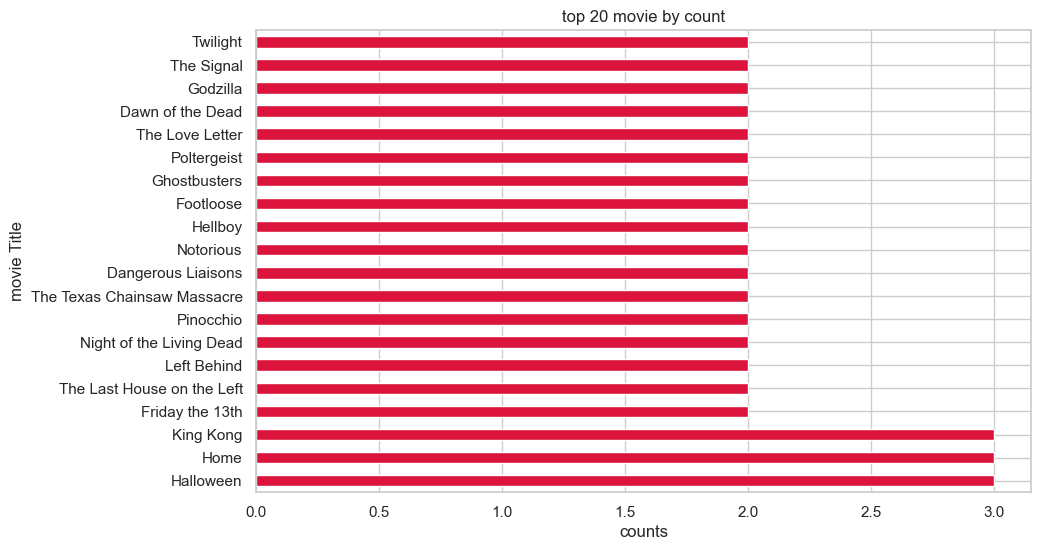

In [212]:
#first 20 titles
merged_df1['movie'].value_counts().head(20)

#plotting
merged_df1['movie'].value_counts().head(20).plot(kind='barh',color='crimson')
plt.title('top 20 movie by count')
plt.ylabel('movie Title')
plt.xlabel('counts')
plt.show()

In [213]:
#first 20 genres
merged_df1['genres'].value_counts().head(20)

#plotting
merged_df1['genres'].value_counts().head(20).plot(kind='bar',color='magenta')
plt.title('top 20 genres by count')
plt.xlabel('Genre')
plt.ylabel('counts')
plt.show()

KeyError: 'genres'

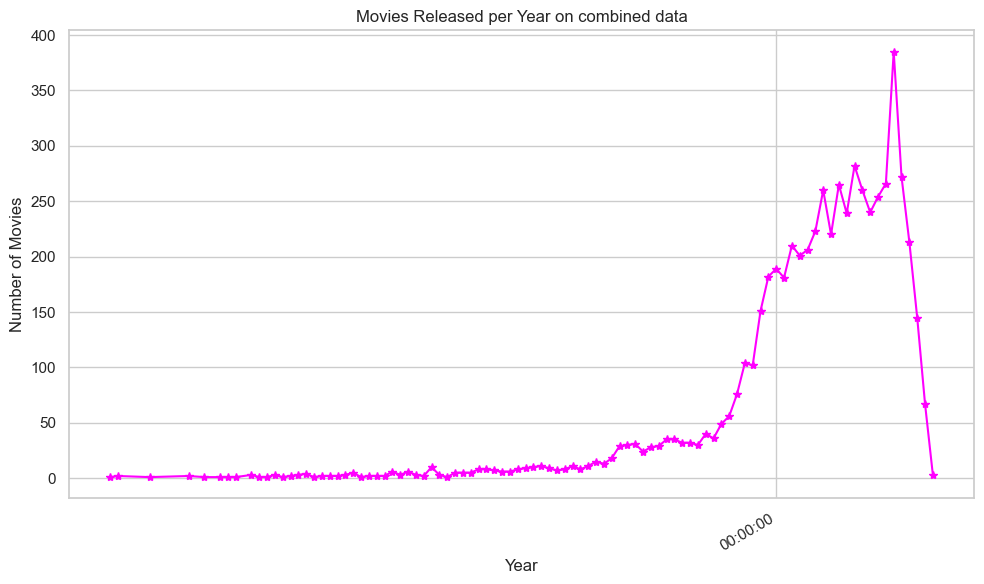

In [ ]:
merged_df1['year'].value_counts().sort_index().plot(kind='line',marker='*',color='magenta')
plt.title('Movies Released per Year on combined data')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print(type(merged_df1['averagerating']))
print(merged_df1['averagerating'].head())
print(merged_df1['averagerating'].shape)


<class 'pandas.core.series.Series'>
0    NaN
1    6.6
2    6.0
3    7.3
4    NaN
Name: averagerating, dtype: float64
(5984,)


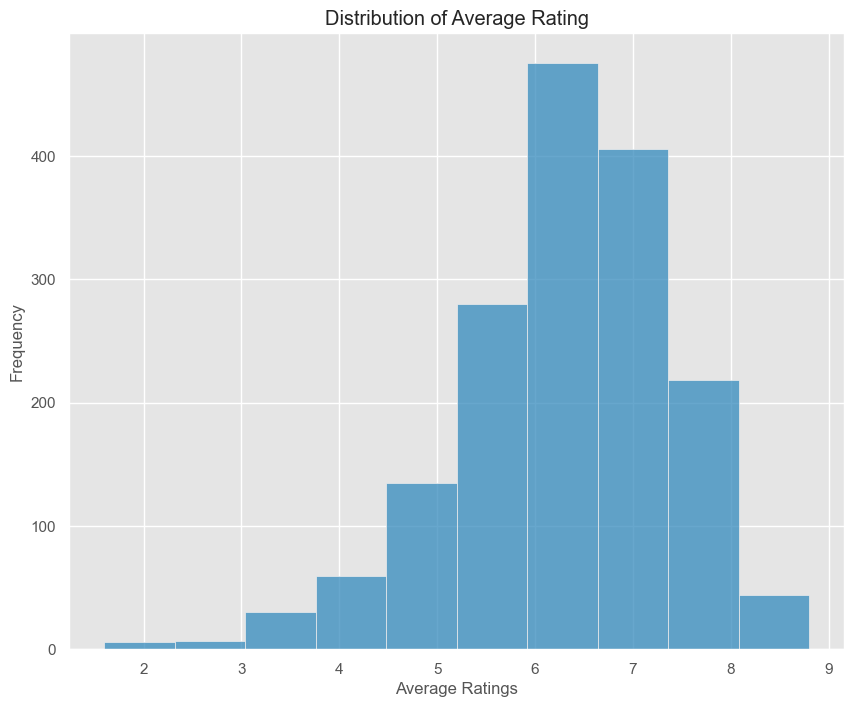

In [ ]:
merged_df1['averagerating'] = (pd.to_numeric(merged_df1['averagerating'], errors='coerce'))

# Plot to see the Distributio of average ratings of genres in our combined_df DataFrame
plt.figure(figsize = (10, 8))

plt.style.use('ggplot')

sns.histplot(merged_df1['averagerating'].squeeze(), bins = 10) # Histogram with 10 bins
plt.title('Distribution of Average Rating')
plt.xlabel('Average Ratings')
plt.ylabel('Frequency')
plt.show()

hypothesis testing